
Verwendetes Szenario: office
Vorhandene Ladepunkte am Standort: 3
Erster Timestamp:  2025-12-01 00:00:00
Letzter Timestamp: 2025-12-02 23:45:00
Simulationshorizont: 2 Tage

📊 Sessions im Simulationshorizont
BEV-Ankünfte mit Ladebedarf: 19
BEV-Fahrzeuge mit Ladezugang: 8
BEV ohne Ladezugang (drive_off): 11
Alle BEV-Fahrzeuge haben ihr Ziel-SoC erreicht.

Kalenderische Tage je Tagtyp:
- working_day: 2 Tage
- saturday: 0 Tage
- sunday_holiday: 0 Tage


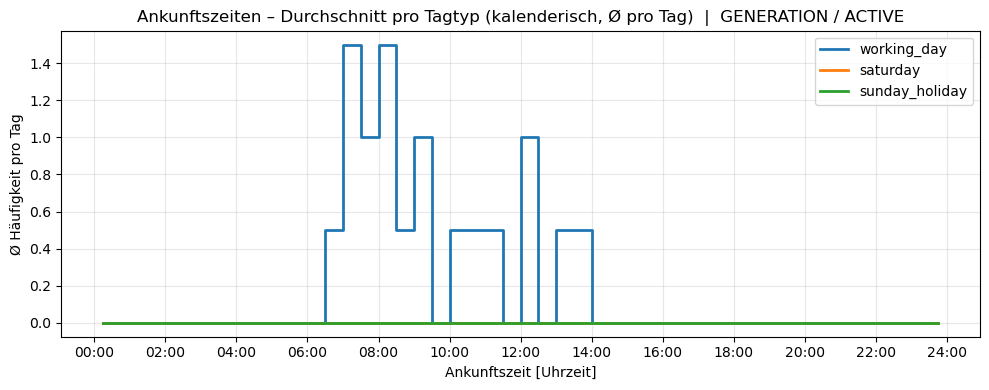

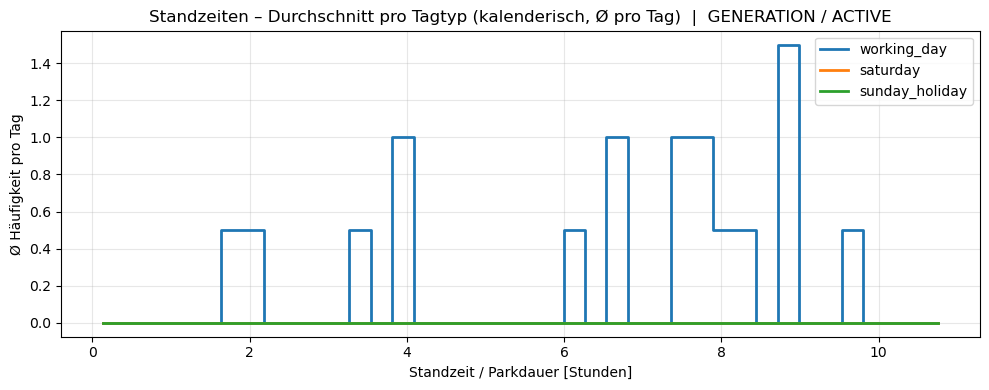

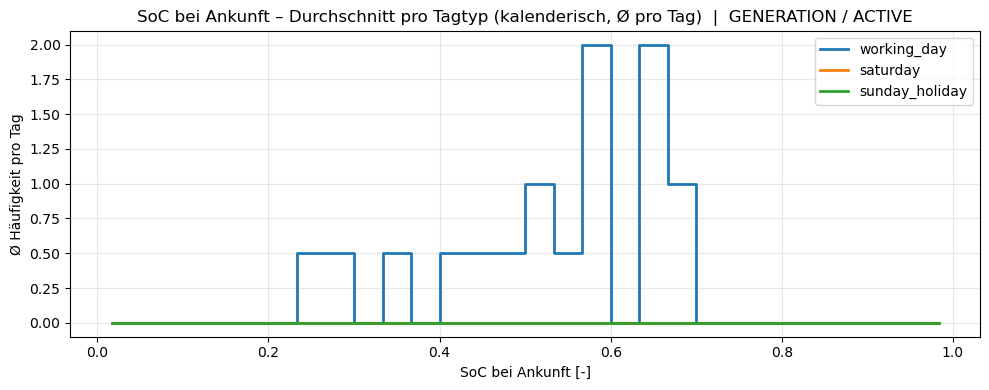

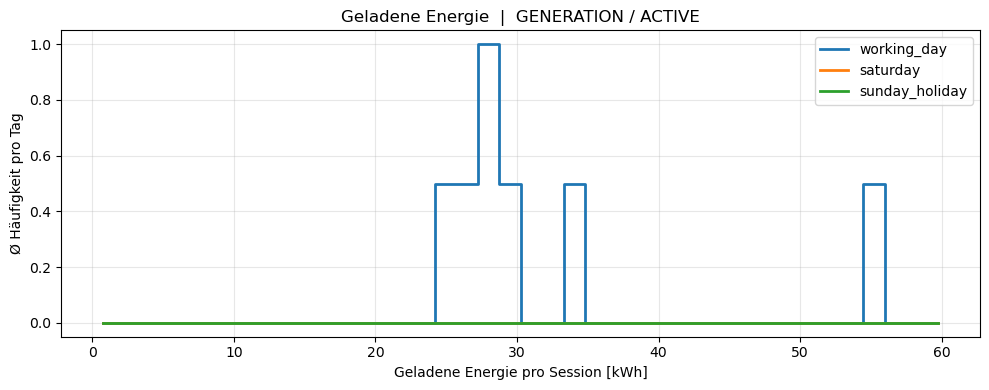

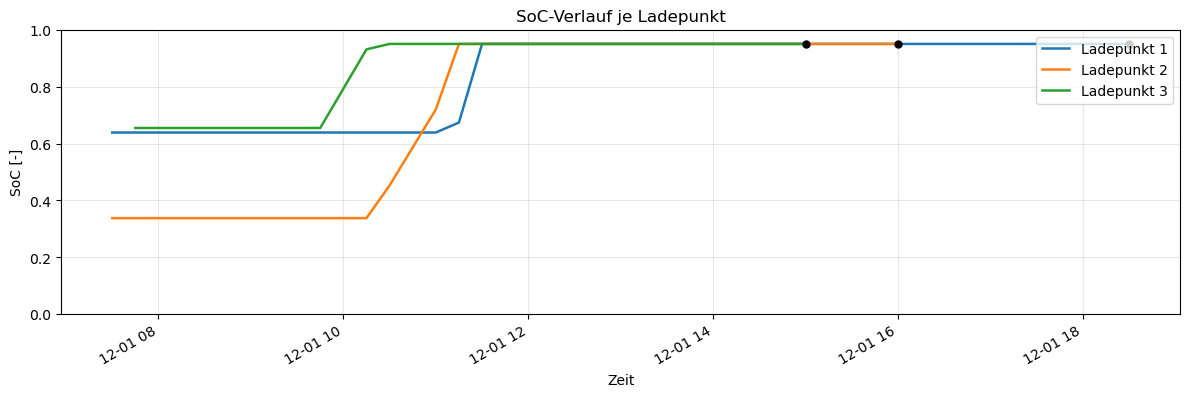

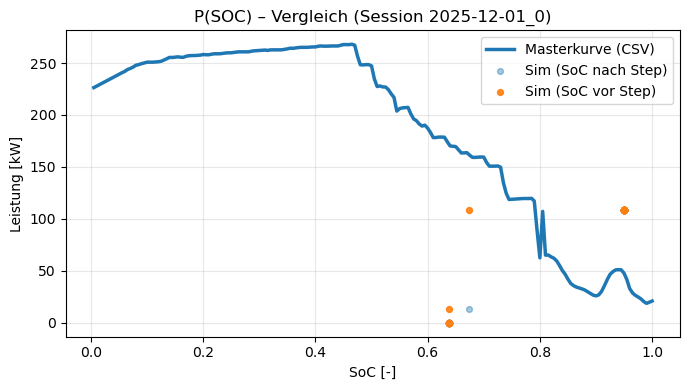

KeyError: 'pmax_vehicle_kw'

In [27]:
# =============================================================================
# GLOBAL SETUP (NEU) – einmal pro Notebook ganz oben ausführen
# =============================================================================

# --- Szenario / Fenster-Defaults ---
scenario_name = "office"
scenario_path = f"../scenarios/{scenario_name}.yaml"

# Standard-Zoom: 1 Tag ab Start (wird nach Simulation gesetzt)
steps_per_day = None
t0 = None
t1 = None

def init_time_window(timestamps, scenario: dict, days: int = 1):
    """
    Definiert ein robustes Default-Zeitfenster (t0, t1) basierend auf timestamps + scenario.
    days=1 => 1 Tag Zoom ab Start
    """
    if timestamps is None or len(timestamps) == 0:
        return None, None, None

    steps_per_day_local = int(24 * 60 / int(scenario["time_resolution_min"]))
    steps = int(max(1, days)) * steps_per_day_local

    t0_local = pd.to_datetime(timestamps[0])
    t1_local = pd.to_datetime(timestamps[min(len(timestamps) - 1, steps - 1)])
    return steps_per_day_local, t0_local, t1_local


# =============================================================================
# Imports
# =============================================================================
import sys
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime, timedelta
from IPython.display import display, HTML

warnings.simplefilter("always", UserWarning)

# =============================================================================
# 0) Plot-Farben (global konsistent)
# =============================================================================
COLOR_GENERATION = "green"     # Erzeugung / PV / Strategy (generation)
COLOR_LOAD = "orange"          # Last / EV / Standortlast
COLOR_BASELOAD = "#7f7f7f"     # Grundlast (neutral grau)
COLOR_MARKET = "tab:blue"      # Marktpreis (market)

# =============================================================================
# 1) Notebook-UI Helpers
# =============================================================================
def show_strategy_status_html(charging_strategy: str, strategy_status: str) -> None:
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()

    color_map = {"ACTIVE": "#1a7f37", "INACTIVE": "#c62828", "IMMEDIATE": "#616161"}
    emoji_map = {"ACTIVE": "🟢", "INACTIVE": "🔴", "IMMEDIATE": "⚪"}

    color = color_map.get(status, "#616161")
    emoji = emoji_map.get(status, "⚪")

    html = f"""
    <div style="
        font-size:18px; font-weight:800; color:{color};
        padding:10px 12px; border:2px solid {color};
        border-radius:12px; display:flex; align-items:center;
        gap:10px; width:fit-content; margin:8px 0 14px 0;
        background: rgba(0,0,0,0.02);
    ">
      <span style="font-size:22px">{emoji}</span>
      <div>
        <div>Charging strategy: <span style="letter-spacing:0.5px">{strat}</span></div>
        <div>Strategy status: <span style="letter-spacing:0.5px">{status}</span></div>
      </div>
    </div>
    """
    display(HTML(html))


def decorate_title_with_status(base_title: str, charging_strategy: str, strategy_status: str) -> str:
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()
    return f"{base_title}  |  {strat} / {status}"


# =============================================================================
# 2) Projektpfad setzen, damit "model" importierbar ist
# =============================================================================
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

# =============================================================================
# 2b) Imports aus dem Simulationsmodul
# =============================================================================
from model.simulation import (
    load_scenario,
    simulate_load_profile,
    build_base_load_series,
    summarize_sessions,
    get_daytype_calendar,
    group_sessions_by_day,
    build_pv_unused_table,
)

try:
    from model.simulation import summarize_sessions_by_charging_mode, summarize_energy_by_charging_mode
except Exception:
    summarize_sessions_by_charging_mode = None
    summarize_energy_by_charging_mode = None

try:
    from model.simulation import build_strategy_signal_series  # optional
except Exception:
    build_strategy_signal_series = None


# =============================================================================
# 3) Szenario laden und Simulation durchführen
# =============================================================================
scenario = load_scenario(scenario_path)

try:
    (
        timestamps,
        load_kw,
        sessions,
        charging_counts,
        holiday_dates,
        charging_strategy,
        strategy_status,
        debug_rows,
        charger_traces,
    ) = simulate_load_profile(
        scenario,
        record_debug=True,
        record_charger_traces=True,
    )
except ValueError as e:
    print("\n❌ Simulation abgebrochen:\n")
    print(str(e))
    raise

show_strategy_status_html(charging_strategy, strategy_status)

# Charger-Traces als DataFrame (robust)
df_tr = pd.DataFrame(charger_traces if charger_traces is not None else [])

# --- (NEU) Default-Zeitfenster direkt nach Simulation setzen ---
steps_per_day, t0, t1 = init_time_window(timestamps=timestamps, scenario=scenario, days=1)


# =============================================================================
# 4) Strategie-Signalreihen (optional) – Generation + Market separat
# =============================================================================
generation_series = None
generation_ylabel = None

market_series = None
market_ylabel = None

if build_strategy_signal_series is not None:
    if charging_strategy.lower() == "generation":
        generation_series, generation_ylabel = build_strategy_signal_series(
            scenario=scenario,
            timestamps=timestamps,
            charging_strategy="generation",
            normalize_to_internal=True,  # -> kW
            strategy_resolution_min=15,
        )
        market_series, market_ylabel = build_strategy_signal_series(
            scenario=scenario,
            timestamps=timestamps,
            charging_strategy="market",
            normalize_to_internal=True,  # -> €/kWh
            strategy_resolution_min=15,
        )
    elif charging_strategy.lower() == "market":
        market_series, market_ylabel = build_strategy_signal_series(
            scenario=scenario,
            timestamps=timestamps,
            charging_strategy="market",
            normalize_to_internal=True,  # -> €/kWh
            strategy_resolution_min=15,
        )


# =============================================================================
# 5) Timeseries-DataFrame (NEU) – Einheitliche Basis für Plots
# =============================================================================
def make_timeseries_df(
    timestamps,
    ev_load_kw: np.ndarray,
    scenario: dict,
    debug_rows: list[dict] | None = None,
    generation_series: np.ndarray | None = None,
    market_series: np.ndarray | None = None,
) -> pd.DataFrame:
    # Basis: EV-Last aus Simulation
    df = pd.DataFrame({
        "ts": pd.to_datetime(timestamps),
        "ev_load_kw": np.asarray(ev_load_kw, dtype=float)
    })

    # 1) Debug zuerst mergen (ist "Quelle der Wahrheit", wenn vorhanden)
    if debug_rows is not None:
        df_dbg = pd.DataFrame(debug_rows).copy()
        if len(df_dbg) > 0 and "ts" in df_dbg.columns:
            df_dbg["ts"] = pd.to_datetime(df_dbg["ts"], errors="coerce")
            df_dbg = df_dbg.dropna(subset=["ts"]).drop_duplicates(subset=["ts"], keep="first")
            df = df.merge(df_dbg, on="ts", how="left")

    # 2) Base Load: bevorzugt aus Debug, sonst aus build_base_load_series
    if "base_load_kw" not in df.columns or df["base_load_kw"].isna().all():
        base_load_kw_series = build_base_load_series(
            scenario=scenario,
            timestamps=timestamps,
            base_load_resolution_min=15
        )
        if base_load_kw_series is None:
            base_load_kw_series = np.zeros_like(df["ev_load_kw"].values)
        df["base_load_kw"] = np.asarray(base_load_kw_series, dtype=float)

    # 3) Site Load immer konsistent berechnen (falls Debug schon site_load_kw hat, lassen wir ihn drin)
    df["site_load_kw"] = df["ev_load_kw"] + df["base_load_kw"]

    # 4) PV / Market Serien nur setzen, wenn Debug das nicht schon liefert
    if generation_series is not None:
        if "pv_generation_kw" not in df.columns or df["pv_generation_kw"].isna().all():
            df["pv_generation_kw"] = np.asarray(generation_series, dtype=float)
        else:
            # optional: Signal separat halten (sehr hilfreich zum Debuggen)
            df["pv_signal_kw"] = np.asarray(generation_series, dtype=float)

    return df



df_ts = make_timeseries_df(
    timestamps=timestamps,
    ev_load_kw=load_kw,
    scenario=scenario,
    debug_rows=debug_rows,
    generation_series=generation_series,
    market_series=market_series,
)


# =============================================================================
# 6) Kurze Simulation-Infos + KPIs (erweitert)  [NEU: KPI-Block]
# =============================================================================
print("\nVerwendetes Szenario:", scenario_name)
print("Vorhandene Ladepunkte am Standort:", scenario["site"]["number_chargers"])
print(f"Erster Timestamp:  {timestamps[0]}")
print(f"Letzter Timestamp: {timestamps[-1]}")
print(f"Simulationshorizont: {scenario['simulation_horizon_days']} Tage")

summary = summarize_sessions(sessions)

print("\n📊 Sessions im Simulationshorizont")
print("BEV-Ankünfte mit Ladebedarf:", summary["num_sessions_total"])
print("BEV-Fahrzeuge mit Ladezugang:", summary["num_sessions_plugged"])
print("BEV ohne Ladezugang (drive_off):", summary["num_sessions_rejected"])

df_not_reached = pd.DataFrame(summary["not_reached_rows"])
if len(df_not_reached) == 0:
    print("Alle BEV-Fahrzeuge haben ihr Ziel-SoC erreicht.")
else:
    df_not_reached = df_not_reached.sort_values("remaining_energy_kwh", ascending=False).reset_index(drop=True)
    print(f"Anzahl der BEV-Fahrzeuge, die nicht ihr Ziel-SoC erreicht haben: {len(df_not_reached)}")
    display(df_not_reached)


# =============================================================================
# 7) Daytype + Gruppierungen
# =============================================================================
start_dt = datetime.fromisoformat(scenario["start_datetime"])
horizon_days = int(scenario["simulation_horizon_days"])

days_by_type_calendar = get_daytype_calendar(
    start_datetime=start_dt,
    horizon_days=horizon_days,
    holiday_dates=holiday_dates,
)

sessions_by_day = group_sessions_by_day(sessions, only_plugged=False)
sessions_by_day_plugged = group_sessions_by_day(sessions, only_plugged=True)

print("\nKalenderische Tage je Tagtyp:")
for k in ["working_day", "saturday", "sunday_holiday"]:
    print(f"- {k}: {len(days_by_type_calendar.get(k, []))} Tage")


# =============================================================================
# 8) Histogramm-Helper
# =============================================================================
def minutes_since_midnight(dt: datetime) -> float:
    return dt.hour * 60 + dt.minute + dt.second / 60.0

def feat_arrival_hours(s) -> float:
    return minutes_since_midnight(s["arrival_time"]) / 60.0

def feat_parking_hours(s) -> float:
    return (s["departure_time"] - s["arrival_time"]).total_seconds() / 3600.0

def feat_soc_arrival(s) -> float:
    return float(s["soc_arrival"])

def feat_delivered_kwh(s) -> float:
    return float(s.get("delivered_energy_kwh", 0.0))

def average_hist_per_daytype_calendar(
    daytype_to_days: dict,
    sessions_by_day: dict,
    value_fn,
    bin_edges: np.ndarray,
) -> dict[str, np.ndarray]:
    avg_counts_by_type: dict[str, np.ndarray] = {}
    for day_type, days in daytype_to_days.items():
        if not days:
            avg_counts_by_type[day_type] = np.zeros(len(bin_edges) - 1, dtype=float)
            continue

        daily_counts = []
        for d in days:
            sess = sessions_by_day.get(d, [])
            values = np.array([value_fn(s) for s in sess], dtype=float)
            counts, _ = np.histogram(values, bins=bin_edges)
            daily_counts.append(counts.astype(float))

        avg_counts_by_type[day_type] = np.mean(np.vstack(daily_counts), axis=0)

    return avg_counts_by_type

def plot_avg_hist_overlay(
    avg_counts_by_type,
    bin_edges,
    xlabel,
    base_title,
    charging_strategy,
    strategy_status,
    xticks=None,
    xtick_labels=None,
):
    plt.figure(figsize=(10, 4))
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    for dt_type in ["working_day", "saturday", "sunday_holiday"]:
        if dt_type not in avg_counts_by_type:
            continue
        plt.step(centers, avg_counts_by_type[dt_type], where="mid", linewidth=2, label=dt_type)

    plt.xlabel(xlabel)
    plt.ylabel("Ø Häufigkeit pro Tag")
    plt.title(decorate_title_with_status(base_title, charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.legend()

    if xticks is not None:
        plt.xticks(xticks, xtick_labels if xtick_labels is not None else None)

    plt.tight_layout()
    plt.show()


# =============================================================================
# 9) Histogramme (unverändert)
# =============================================================================
if timestamps is not None and sessions is not None and days_by_type_calendar:
    arrival_bin_edges = np.linspace(0, 24, 49)
    avg_arrival = average_hist_per_daytype_calendar(days_by_type_calendar, sessions_by_day, feat_arrival_hours, arrival_bin_edges)
    plot_avg_hist_overlay(
        avg_arrival, arrival_bin_edges,
        xlabel="Ankunftszeit [Uhrzeit]",
        base_title="Ankunftszeiten – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
        xticks=list(range(0, 25, 2)),
        xtick_labels=[f"{h:02d}:00" for h in range(0, 25, 2)],
    )

    all_parking = np.array([feat_parking_hours(s) for s in sessions], dtype=float)
    max_p = max(np.percentile(all_parking, 99) if len(all_parking) else 1.0, 0.5)
    parking_bin_edges = np.linspace(0, max_p, 41)
    avg_parking = average_hist_per_daytype_calendar(days_by_type_calendar, sessions_by_day, feat_parking_hours, parking_bin_edges)
    plot_avg_hist_overlay(
        avg_parking, parking_bin_edges,
        xlabel="Standzeit / Parkdauer [Stunden]",
        base_title="Standzeiten – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
    )

    soc_bin_edges = np.linspace(0, 1, 31)
    avg_soc = average_hist_per_daytype_calendar(days_by_type_calendar, sessions_by_day, feat_soc_arrival, soc_bin_edges)
    plot_avg_hist_overlay(
        avg_soc, soc_bin_edges,
        xlabel="SoC bei Ankunft [-]",
        base_title="SoC bei Ankunft – Durchschnitt pro Tagtyp (kalenderisch, Ø pro Tag)",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
    )

    plugged_list = [s for s in sessions if s.get("_plug_in_time") is not None]
    all_energy = np.array([feat_delivered_kwh(s) for s in plugged_list], dtype=float)
    max_e = max(np.percentile(all_energy, 99) if len(all_energy) else 1.0, 1.0)
    energy_bin_edges = np.linspace(0, max_e, 41)
    avg_energy = average_hist_per_daytype_calendar(days_by_type_calendar, sessions_by_day_plugged, feat_delivered_kwh, energy_bin_edges)
    plot_avg_hist_overlay(
        avg_energy, energy_bin_edges,
        xlabel="Geladene Energie pro Session [kWh]",
        base_title="Geladene Energie",
        charging_strategy=charging_strategy,
        strategy_status=strategy_status,
    )


# =============================================================================
# 10) SoC-Verlauf je Ladepunkt
# =============================================================================
def plot_soc_by_chargers(df_tr, charger_ids=None, start=None, end=None):
    if df_tr is None or len(df_tr) == 0:
        print("Keine Daten in df_tr (leer). Prüfe record_charger_traces=True und Rückgabe von simulate_load_profile().")
        return

    required = {"ts", "charger_id", "occupied", "soc"}
    missing = required - set(df_tr.columns)
    if missing:
        print(f"df_tr hat nicht alle benötigten Spalten. Es fehlen: {sorted(missing)}")
        print("Vorhandene Spalten:", df_tr.columns.tolist())
        return

    d = df_tr.copy()

    d["charger_id"] = pd.to_numeric(d["charger_id"], errors="coerce")
    d = d[d["charger_id"].notna()].copy()
    d["charger_id"] = d["charger_id"].astype(int)

    d["ts"] = pd.to_datetime(d["ts"], errors="coerce")
    d = d[d["ts"].notna()].copy()

    if charger_ids is not None:
        charger_ids_int = [int(x) for x in charger_ids]
        d = d[d["charger_id"].isin(charger_ids_int)]
    if start is not None:
        d = d[d["ts"] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d["ts"] <= pd.to_datetime(end)]

    if d["occupied"].dtype != bool:
        d["occupied"] = d["occupied"].astype(str).str.lower().isin(["true", "1", "yes"])

    d = d[(d["occupied"] == True) & (d["soc"].notna())].copy()

    if len(d) == 0:
        print("Nach Filtern keine belegten Ladepunkte mit SoC im gewählten Zeitfenster gefunden.")
        return

    has_session = ("session_id" in d.columns) and d["session_id"].notna().any()
    d = d.sort_values(["charger_id", "ts"])

    cycle = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])
    charger_ids_sorted = sorted(d["charger_id"].unique().tolist())
    color_by_cid = {cid: cycle[k % len(cycle)] for k, cid in enumerate(charger_ids_sorted)} if cycle else {}

    plt.figure(figsize=(12, 4))
    labeled = set()
    ax = plt.gca()

    for cid, g in d.groupby("charger_id"):
        cid = int(cid)
        c = color_by_cid.get(cid, None)

        label = None
        if cid not in labeled:
            label = f"Ladepunkt {cid + 1}"
            labeled.add(cid)

        if has_session:
            for sid, gg in g.groupby("session_id"):
                gg = gg.sort_values("ts")
                if len(gg) == 0:
                    continue
                ax.plot(gg["ts"], gg["soc"], linewidth=1.8, label=label, color=c)
                label = None
                last = gg.iloc[-1]
                ax.scatter([last["ts"]], [last["soc"]], color="black", s=25, zorder=5)
        else:
            ax.plot(g["ts"], g["soc"], linewidth=1.8, label=label, color=c)
            last = g.iloc[-1]
            ax.scatter([last["ts"]], [last["soc"]], color="black", s=25, zorder=5)

    ax.set_xlabel("Zeit")
    ax.set_ylabel("SoC [-]")
    ax.set_ylim(0, 1.0)
    ax.set_title("SoC-Verlauf je Ladepunkt")
    ax.grid(True, alpha=0.3)

    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    ax.legend(uniq.values(), uniq.keys(), loc="upper right")

    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()


plot_soc_by_chargers(
    df_tr,
    charger_ids=list(range(int(scenario["site"]["number_chargers"]))),
    start=t0,
    end=t1,
)


# =============================================================================
# 10) Ladekurven-CSV
# =============================================================================

# Beispiel: ein charger + eine session
d = df_tr.copy()
d["ts"] = pd.to_datetime(d["ts"])
d = d[(d["occupied"] == True) & (d["charger_id"] == 0) & d["session_id"].notna() & d["soc"].notna()].copy()
sid = d["session_id"].iloc[0]
d = d[d["session_id"] == sid].sort_values("ts")

# Session-Objekt finden (enthält soc_grid/power_grid_kw)
s_obj = next(s for s in sessions if s.get("session_id") == sid)
soc_curve = np.array(s_obj["soc_grid"], dtype=float)
p_curve   = np.array(s_obj["power_grid_kw"], dtype=float)

# SoC am Step-Start approximieren: vorheriger SoC
# (für die erste Zeile nehmen wir soc_arrival aus der Session)
d["soc_start"] = d["soc"].shift(1)
d.loc[d.index[0], "soc_start"] = float(s_obj["soc_arrival"])

plt.figure(figsize=(7,4))
plt.plot(soc_curve, p_curve, linewidth=2.5, label="Masterkurve (CSV)")
plt.scatter(d["soc"].values, d["power_kw"].values, s=18, alpha=0.4, label="Sim (SoC nach Step)")
plt.scatter(d["soc_start"].values, d["power_kw"].values, s=18, alpha=0.9, label="Sim (SoC vor Step)")
plt.xlabel("SoC [-]")
plt.ylabel("Leistung [kW]")
plt.title(f"P(SOC) – Vergleich (Session {sid})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

d["ratio"] = d["power_kw"] / d["pmax_vehicle_kw"]
print("Max ratio:", d["ratio"].max())

d["excess_kw"] = d["power_kw"] - d["pmax_vehicle_kw"]
display(d[d["excess_kw"] > 0].sort_values("excess_kw", ascending=False).head(10))


# =============================================================================
# 11) Leistung einzelner Ladepunkte über die Zeit
# =============================================================================
def plot_power_per_charger(df_tr, charger_id, start=None, end=None):
    d = df_tr[df_tr["charger_id"] == charger_id].copy()

    d["ts"] = pd.to_datetime(d["ts"], errors="coerce")
    d = d[d["ts"].notna()].copy()

    if start is not None:
        d = d[d["ts"] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d["ts"] <= pd.to_datetime(end)]

    plt.figure(figsize=(12, 3))
    plt.plot(d["ts"], d["power_kw"], linewidth=2.0)
    plt.xlabel("Zeit")
    plt.ylabel("Leistung [kW]")
    plt.title(f"Ladeleistung – Ladepunkt {charger_id + 1}")
    plt.grid(True, alpha=0.3)

    d2 = d.sort_values("ts")
    if "session_id" in d2.columns and "occupied" in d2.columns and d2["session_id"].notna().any():
        session_change = d2["session_id"].ne(d2["session_id"].shift(1))
        starts = d2[session_change & d2["occupied"] & d2["session_id"].notna()]
        for _, r in starts.iterrows():
            label = f"{r.get('vehicle_name', '')}"
            plt.text(r["ts"], r["power_kw"], label, fontsize=8, rotation=20)

    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()


plot_power_per_charger(df_tr, charger_id=0, start=t0, end=t1)


# =============================================================================
# 12) Fahrzeugzählung
# =============================================================================
sessions_plugged = [s for s in sessions if s.get("_plug_in_time") is not None]
counts = Counter([s.get("vehicle_name", "") for s in sessions_plugged])

plt.figure(figsize=(12, 5))
plt.bar(list(counts.keys()), list(counts.values()), edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Fahrzeugmodell")
plt.ylabel("Anzahl Ladesessions (plugged)")
plt.title(decorate_title_with_status("Geladene Fahrzeugmodelle", charging_strategy, strategy_status))
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


# =============================================================================
# 13) Strategy-Only Plots – Erzeugung und Marktpreis getrennt 
# =============================================================================
if generation_series is not None and generation_ylabel is not None:
    plt.figure(figsize=(12, 4))
    plt.plot(timestamps, generation_series, linewidth=2, color=COLOR_GENERATION)
    plt.xlabel("Zeit")
    plt.ylabel(generation_ylabel)
    plt.title(decorate_title_with_status("Erzeugungssignal (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

if market_series is not None and market_ylabel is not None:
    plt.figure(figsize=(12, 4))
    plt.plot(timestamps, market_series, linewidth=2, color=COLOR_MARKET)
    plt.xlabel("Zeit")
    plt.ylabel(market_ylabel)
    plt.title(decorate_title_with_status("Marktpreissignal (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()


# =============================================================================
# 14) Master-Plots
# =============================================================================
def plot_site_overview(
    df_ts: pd.DataFrame,
    scenario: dict,
    charging_strategy: str,
    strategy_status: str,
    start=None,
    end=None,
):
    d = df_ts.copy()
    if start is not None:
        d = d[d["ts"] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d["ts"] <= pd.to_datetime(end)]

    if len(d) == 0:
        print("plot_site_overview: kein Datenfenster.")
        return

    fig, ax = plt.subplots(figsize=(12, 4))

    ax.plot(
        d["ts"],
        d["site_load_kw"],
        linewidth=2.0,
        color=COLOR_LOAD,
        label="Standortlast (EV+Base) [kW]",
    )

    # PV-Erzeugung exakt aus generation_series -> df_ts["pv_generation_kw"]
    if "pv_generation_kw" in d.columns and d["pv_generation_kw"].notna().any():
        ax.plot(
            d["ts"],
            d["pv_generation_kw"],
            linewidth=1.8,
            color=COLOR_GENERATION,
            alpha=0.9,
            label="PV-Erzeugung [kW]",
        )

    if "grid_import_kw_site" in d.columns and d["grid_import_kw_site"].notna().any():
        ax.plot(
            d["ts"],
            d["grid_import_kw_site"],
            linewidth=1.6,
            color="black",
            alpha=0.75,
            label="Netzimport [kW]",
        )
        gl = float(scenario["site"]["grid_limit_p_avb_kw"])
        ax.axhline(
            gl,
            linewidth=1.2,
            alpha=0.6,
            linestyle="--",
            color="black",
            label="Grid-Limit [kW]",
        )

    ax.set_xlabel("Zeit")
    ax.set_ylabel("Leistung [kW]")
    ax.set_title(
        decorate_title_with_status(
            "Übersicht: Standortlast / PV / Netzimport",
            charging_strategy,
            strategy_status,
        )
    )
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right")
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


def plot_market_behavior_zoom(df_ts: pd.DataFrame, charging_strategy: str, strategy_status: str, start=None, end=None):
    d = df_ts.copy()
    if start is not None:
        d = d[d["ts"] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d["ts"] <= pd.to_datetime(end)]

    if len(d) == 0:
        print("plot_market_behavior_zoom: kein Datenfenster.")
        return
    if "price_eur_per_kwh" not in d.columns or not d["price_eur_per_kwh"].notna().any():
        print("plot_market_behavior_zoom: kein Market-Preis in df_ts.")
        return

    fig, ax1 = plt.subplots(figsize=(12, 4))
    ax1.plot(d["ts"], d["site_load_kw"], linewidth=2.0, color=COLOR_LOAD, label="Standortlast (EV+Base) [kW]")
    ax1.set_xlabel("Zeit")
    ax1.set_ylabel("Leistung [kW]")
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.step(d["ts"], d["price_eur_per_kwh"], where="post", linewidth=1.6, color=COLOR_MARKET, alpha=0.9, label="Preis [€/kWh]")
    ax2.set_ylabel("Preis [€/kWh]")

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper right")

    ax1.set_title(decorate_title_with_status("Market-Zoom: Last vs. Preis", charging_strategy, strategy_status))
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


def plot_charger_power_heatmap(df_tr: pd.DataFrame, scenario: dict, charging_strategy: str, strategy_status: str, start=None, end=None):
    if df_tr is None or len(df_tr) == 0:
        print("plot_charger_power_heatmap: df_tr leer.")
        return

    required = {"ts", "charger_id", "power_kw"}
    missing = required - set(df_tr.columns)
    if missing:
        print(f"plot_charger_power_heatmap: df_tr fehlen Spalten: {sorted(missing)}")
        return

    d = df_tr.copy()
    d["ts"] = pd.to_datetime(d["ts"], errors="coerce")
    d = d[d["ts"].notna()].copy()

    d["charger_id"] = pd.to_numeric(d["charger_id"], errors="coerce")
    d = d[d["charger_id"].notna()].copy()
    d["charger_id"] = d["charger_id"].astype(int)

    if start is not None:
        d = d[d["ts"] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d["ts"] <= pd.to_datetime(end)]

    if len(d) == 0:
        print("plot_charger_power_heatmap: kein Datenfenster.")
        return

    pv = d.pivot_table(index="charger_id", columns="ts", values="power_kw", aggfunc="first").sort_index()

    fig, ax = plt.subplots(figsize=(12, 3.8))
    im = ax.imshow(pv.values, aspect="auto", interpolation="nearest")

    ax.set_title(decorate_title_with_status("Heatmap: Ladeleistung je Ladepunkt", charging_strategy, strategy_status))
    ax.set_xlabel("Zeit")
    ax.set_ylabel("Ladepunkt")

    yt = np.arange(pv.shape[0])
    ax.set_yticks(yt)
    ax.set_yticklabels([f"LP {i+1}" for i in pv.index])

    cols = pv.columns.to_list()
    if len(cols) > 1:
        n_ticks = min(8, len(cols))
        tick_idx = np.linspace(0, len(cols) - 1, n_ticks).astype(int)
        ax.set_xticks(tick_idx)
        ax.set_xticklabels([pd.to_datetime(cols[i]).strftime("%H:%M") for i in tick_idx], rotation=0)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Leistung [kW]")
    plt.tight_layout()
    plt.show()


# --- Master-Plots ausführen (t0/t1 kommen aus Global Setup direkt nach Simulation) ---
plot_site_overview(df_ts, scenario, charging_strategy, strategy_status)
plot_site_overview(df_ts, scenario, charging_strategy, strategy_status, start=t0, end=t1)
if "price_eur_per_kwh" in df_ts.columns and df_ts["price_eur_per_kwh"].notna().any():
    plot_market_behavior_zoom(df_ts, charging_strategy, strategy_status, start=t0, end=t1)
plot_charger_power_heatmap(df_tr, scenario, charging_strategy, strategy_status, start=t0, end=t1)


# =============================================================================
# 15) Gestapelte Standortlast (Grundlast + EV) (unverändert, aber nutzt df_ts)
# =============================================================================
plt.figure(figsize=(12, 4))
plt.stackplot(
    df_ts["ts"],
    df_ts["base_load_kw"],
    df_ts["ev_load_kw"],
    labels=["Grundlast (nicht-flexibel)", "EV-Ladeleistung"],
    colors=[COLOR_BASELOAD, COLOR_LOAD],
    alpha=0.9,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(decorate_title_with_status("Standortlast – Grundlast + EV-Ladeleistung (gestapelt)", charging_strategy, strategy_status))
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()


# =============================================================================
# 16) Plugged Sessions Preview Table (unverändert)
# =============================================================================
def build_plugged_sessions_preview_table(sessions, n: int = 20) -> pd.DataFrame:
    if not sessions:
        return pd.DataFrame()

    plugged_sessions = [s for s in sessions if s.get("_plug_in_time") is not None]
    if not plugged_sessions:
        return pd.DataFrame()

    plugged_sessions = sorted(plugged_sessions, key=lambda s: s["arrival_time"])

    rows = []
    for s in plugged_sessions[:n]:
        arrival = s.get("arrival_time")
        departure = s.get("departure_time")

        parking_h = None
        if arrival and departure:
            parking_h = (departure - arrival).total_seconds() / 3600.0

        rows.append(
            {
                "vehicle_name": s.get("vehicle_name", ""),
                "date": arrival.date() if arrival else None,
                "arrival_time": arrival.strftime("%H:%M") if arrival else None,
                "departure_time": departure.strftime("%H:%M") if departure else None,
                "parking_hours": parking_h,
                "delivered_energy_kwh": float(s.get("delivered_energy_kwh", 0.0)),
                "remaining_energy_kwh": float(s.get("energy_required_kwh", 0.0)),
                "charger_id": s.get("_charger_id"),
            }
        )

    df = pd.DataFrame(rows)
    df["parking_hours"] = df["parking_hours"].round(2)
    df["delivered_energy_kwh"] = df["delivered_energy_kwh"].round(2)
    df["remaining_energy_kwh"] = df["remaining_energy_kwh"].round(2)
    return df

df_plugged_preview = build_plugged_sessions_preview_table(sessions, n=20)
display(df_plugged_preview)


# =============================================================================
# 17) Debugging: Nutzung der Lademodi (generation / market / immediate) (unverändert)
# =============================================================================
try:
    from model.simulation import (
        summarize_sessions_by_charging_mode,
        summarize_energy_by_charging_mode,
    )

    mode_counts = summarize_sessions_by_charging_mode(sessions)
    mode_energy = summarize_energy_by_charging_mode(sessions)

    print("\n🧩 Nutzung der Lademodi – Sessions")
    print(f"Sessions mit Ladevorgang insgesamt: {mode_counts['sessions_with_any_charging']}")
    print(f"Sessions mit PV-Ladung:             {mode_counts['sessions_charged_with_generation']}")
    print(f"Sessions mit Marktladen:            {mode_counts['sessions_charged_with_market']}")
    print(f"Sessions mit Sofortladen:           {mode_counts['sessions_charged_with_immediate']}")
    print(f"Sessions mit mehreren Modi:         {mode_counts['sessions_with_multiple_modes']}")

    print("\n⚡ Geladene Energie nach Lademodus [kWh]")
    print(f"Generation:   {mode_energy['generation']:.2f}")
    print(f"Market:       {mode_energy['market']:.2f}")
    print(f"Immediate:    {mode_energy['immediate']:.2f}")

except Exception as e:
    print("\n⚠️ Debugging-Helper konnte nicht importiert werden.")
    print(str(e))


##Mini-Check
print("max |base_df - base_dbg| =", float((df_ts["base_load_kw"] - df_ts["base_load_kw"]).abs().max()) if "base_load_kw" in df_ts else None)

cols = [c for c in ["site_load_kw","grid_import_kw_site","pv_generation_kw","ev_load_kw","base_load_kw"] if c in df_ts.columns]
print("cols:", cols)

# finde den Timestamp mit größter Abweichung zwischen Debug-Import und Bilanz-Import
df_ts["grid_import_kw_site_calc"] = (df_ts["site_load_kw"] - df_ts["pv_generation_kw"]).clip(lower=0.0)
df_ts["diff"] = df_ts["grid_import_kw_site"] - df_ts["grid_import_kw_site_calc"]
i = df_ts["diff"].abs().idxmax()
display(df_ts.loc[[i], ["ts","ev_load_kw","base_load_kw","site_load_kw","pv_generation_kw","grid_import_kw_site","grid_import_kw_site_calc","diff"]])

df_ts["grid_import_kw_site_calc"] = (df_ts["site_load_kw"] - df_ts["pv_generation_kw"]).clip(lower=0.0)
df_ts["diff"] = df_ts["grid_import_kw_site"] - df_ts["grid_import_kw_site_calc"]

i = df_ts["diff"].abs().idxmax()
display(df_ts.loc[[i], ["ts","ev_load_kw","base_load_kw","site_load_kw","pv_generation_kw",
                       "grid_import_kw_site","grid_import_kw_site_calc","diff"]])

